In [207]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acf, pacf
from pmdarima.arima import auto_arima
from scipy import stats
from sklearn.model_selection import train_test_split
import bsts
from sklearn.metrics import mean_squared_error
from scipy import fftpack
import numpy.polynomial.chebyshev as cheb
import math
from scipy.optimize import curve_fit

In [208]:
data = []

df = pd.read_excel('C:/Users/katya/OneDrive/Рабочий стол/_/НГТУ/8 семестр/КМ/новые_данные.xlsx',index_col=None, header=None)
for i in range (0,len(df)):
    data.append(round(df.values[i][0],2))

data_ = pd.Series(data) # Временной ряд

In [209]:
# Тренды
def linear_func(x, a, b):
    return a*x + b
    
def quadratic_func(x, a, b, c):
    return a*x*x + b*x + c

def cubic_func(x, a, b, c, d):
    return a*x*x*x + b*x*x + c*x + d

In [210]:
# Выделяем трендовую составляющую 
#data = data_train
x = np.arange(len(data_))
y = data_

In [211]:
#   мнк линейная функция
# popt, _ = curve_fit(linear_func, x, y)
# predictions = linear_func(x, *popt)

#   мнк квадратичная функция
# popt, _ = curve_fit(quadratic_func, x, y)
# predictions = quadratic_func(x, *popt)

#   мнк экспоненциальная функция
# popt, _ = curve_fit(exponential_func, x, y)
# predictions = exponential_func(x, *popt)

#   Многочлены Чебышева
degree = 5
coefficients = cheb.chebfit(np.arange(len(y)), y, degree)
predictions = cheb.chebval(x, coefficients)

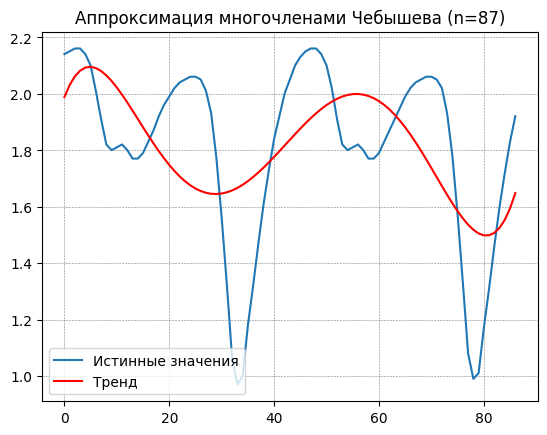

In [212]:
# Построение графика аппроксимации временного ряда    
plt.plot(x, y, label='Истинные значения')
plt.plot(x, predictions, 'r', label='Тренд')
plt.title('Аппроксимация многочленами Чебышева (n={})'.format(len(y)))
plt.legend()
plt.grid(True, linestyle='--', linewidth=0.4, color='gray')
plt.show()

In [213]:
# Удаляем трендовую составляющую из временного ряда (тестового набора)
without_trend = data_ - predictions

In [214]:
# Переходим к выявлению сезонности

In [215]:
# подсчёт коэффициентов Фурье
def fourier_coefficients(x, n_harmonics):
    n = len(x)
    t = np.arange(0, n)
    T = n
    coefficients = []
    for k in range(1, n_harmonics + 1):
        a_k = 2 * np.sum(x * np.cos(2 * np.pi * k * t / T)) / n
        b_k = 2 * np.sum(x * np.sin(2 * np.pi * k * t / T)) / n
        coefficients.append((a_k, b_k))
    return coefficients

# вычисляем сезонную компоненту по Фурье-формуле
def fourier_series(t, coefficients):
    n_harmonics = len(coefficients)
    T = len(t)
    f_series = np.zeros(T)
    for i in range(n_harmonics):
        a_k, b_k = coefficients[i]
        f_series += a_k * np.cos(2 * np.pi * (i+1) * t / T) + b_k * np.sin(2 * np.pi * (i+1) * t / T)
    return f_series

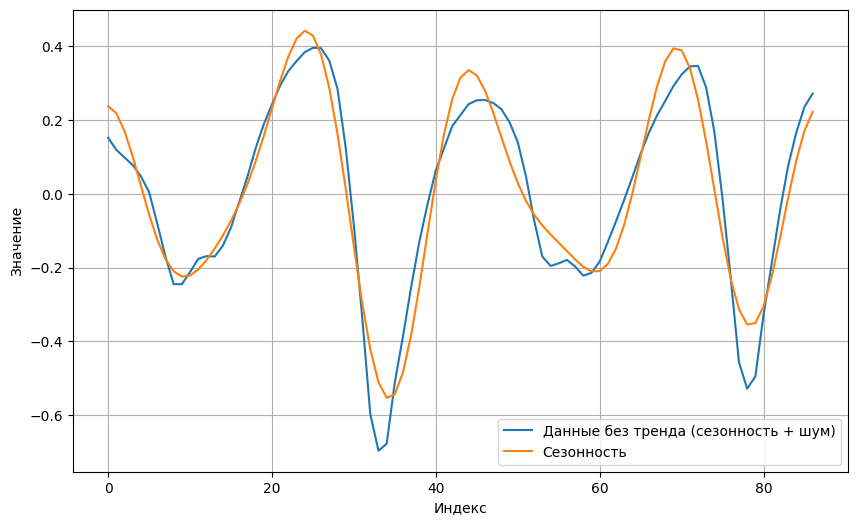

In [216]:
# вычисляем Фурье-коэффициенты
n_harmonics = 6 # задаем количество гармоник
coefficients = fourier_coefficients(without_trend, n_harmonics)

# построение сезонной компоненты
t = np.arange(len(without_trend))
seasonality = fourier_series(t, coefficients)

# Построение графика
plt.figure(figsize=(10, 6))
plt.plot(without_trend.values, label='Данные без тренда (сезонность + шум)')
plt.plot(seasonality, label='Сезонность')
plt.xlabel('Индекс')
plt.ylabel('Значение')
plt.legend()
plt.grid(True)
plt.show()

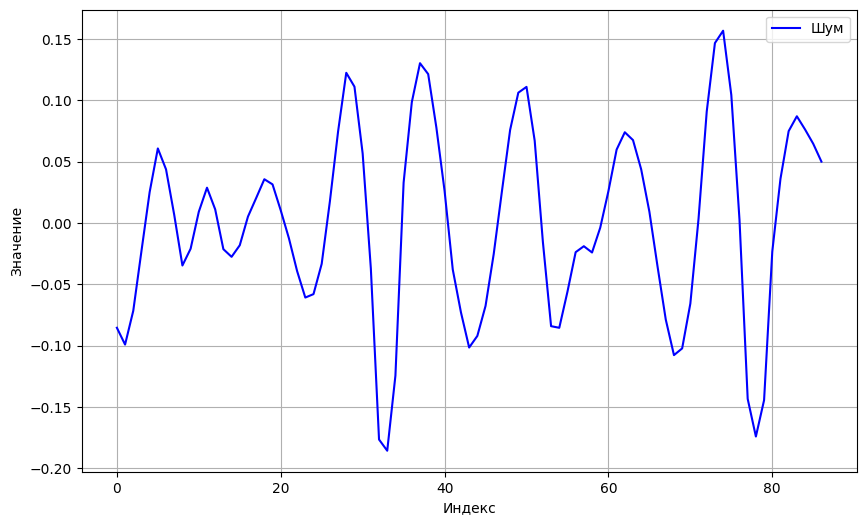

In [217]:
noise = without_trend.values - seasonality
# Построение графика шума
plt.figure(figsize=(10, 6))
plt.plot(noise, label='Шум', color='blue')
plt.xlabel('Индекс')
plt.ylabel('Значение')
plt.legend()
plt.grid(True)
plt.show()

In [218]:
from scipy.stats import shapiro

# Проводим тест Шапиро-Уилка
statistic, p_value = shapiro(noise)

# Выводим результат теста
alpha = 0.05
print(f'Статистика теста: {statistic}, p-значение: {p_value}')
if p_value > alpha:
    print('Шум имеет нормальное распределение')
else:
    print('Шум не имеет нормальное распределение')

Статистика теста: 0.9867528018915429, p-значение: 0.5228493616785646
Шум имеет нормальное распределение
